In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from sklearn.utils import resample
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from tqdm import tqdm
# from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools

Read the data

In [2]:
df = pd.read_csv('bot_iot.csv')
df.shape

C:\Users\009kr\AppData\Local\Temp\ipykernel_11604\3036118028.py:1: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bot_iot.csv')


(668522, 46)

In [3]:
df.head()

,pkSeqID,stime,flgs,flgs_number,proto,proto_number,saddr,sport,daddr,dport,...,AR_P_Proto_P_DstIP,N_IN_Conn_P_DstIP,N_IN_Conn_P_SrcIP,AR_P_Proto_P_Sport,AR_P_Proto_P_Dport,Pkts_P_State_P_Protocol_P_DestIP,Pkts_P_State_P_Protocol_P_SrcIP,attack,category,subcategory
0,3000001,1.528099e+09,e,1,udp,3,192.168.100.147,6226,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
1,3000002,1.528099e+09,e,1,udp,3,192.168.100.147,6227,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
2,3000003,1.528099e+09,e,1,udp,3,192.168.100.147,6228,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
3,3000004,1.528099e+09,e,1,udp,3,192.168.100.147,6229,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP
4,3000005,1.528099e+09,e,1,udp,3,192.168.100.147,6230,192.168.100.3,80,...,1.09825,100,100,1.09827,1.09825,1500,1500,1,DDoS,UDP


In [4]:
df.category.unique()

array(['DDoS', 'Normal', 'Reconnaissance', 'Theft'], dtype=object)

In [5]:
df['category'] = df['category'].apply(lambda x: x if x in ['DDoS'] else 'Other')

In [6]:
#label encode the output column
category_map = {'DDoS':0, 'Other':1}
df['category'] = df['category'].replace(category_map)

C:\Users\009kr\AppData\Local\Temp\ipykernel_11604\355839375.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['category'] = df['category'].replace(category_map)


In [7]:
df.category.value_counts()

category
0    576884
1     91638
Name: count, dtype: int64

In [8]:
df.pkSeqID.unique().size

668522

Check information regarding the features

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   pkSeqID                           668522 non-null  int64  
 1   stime                             668522 non-null  float64
 2   flgs                              668522 non-null  object 
 3   flgs_number                       668522 non-null  int64  
 4   proto                             668522 non-null  object 
 5   proto_number                      668522 non-null  int64  
 6   saddr                             668522 non-null  object 
 7   sport                             668522 non-null  object 
 8   daddr                             668522 non-null  object 
 9   dport                             668522 non-null  object 
 10  pkts                              668522 non-null  int64  
 11  bytes                             668522 non-null  i

In [10]:
df['Pkts_P_State_P_Protocol_P_SrcIP'] == df['AR_P_Proto_P_SrcIP']

0         False
1         False
2         False
3         False
4         False
          ...  
668517    False
668518    False
668519    False
668520    False
668521    False
Length: 668522, dtype: bool

Data Preprocessing

In [11]:
df.flgs.unique()

array(['e', 'eU', 'e &', 'e d', 'e   t', 'e s', 'e  D', 'e *', 'e g'],
      dtype=object)

In [12]:
#Features not useful
df = df.drop(['flgs','flgs_number'], axis = 1)

In [13]:
df.proto.unique()

array(['udp', 'arp', 'icmp', 'tcp', 'ipv6-icmp'], dtype=object)

In [14]:
#Similar feature exists in numeric format
df = df.drop(['proto'],axis=1)

In [15]:
df.proto_number.unique()

array([3, 2, 4, 1, 5], dtype=int64)

In [16]:
df.saddr.unique()

array(['192.168.100.147', '192.168.100.148', '192.168.100.149',
       '192.168.100.150', '192.168.100.3', '192.168.100.1',
       '192.168.100.7', '192.168.100.4', '192.168.100.27',
       'fe80::250:56ff:febe:254', '192.168.100.46', '192.168.100.6',
       '192.168.100.5', 'fe80::250:56ff:febe:26db',
       'fe80::250:56ff:febe:e9d9', 'fe80::c0c0:aa20:45b9:bdd9',
       'fe80::250:56ff:febe:89ee', 'fe80::2c6a:ff9b:7e14:166a',
       'fe80::250:56ff:febe:bf1a', 'fe80::250:56ff:febe:c038',
       '192.168.100.55'], dtype=object)

In [17]:
#Convert ip/mac addresses to a more useable format
def conv_ip_addr(ip_addr):
    ip_addr = ip_addr.replace(':','.')
    temp = ip_addr.split('.')
    op = ''.join(temp)
    if op.isnumeric():
        op = int(op)
    else:
        op =int(op, 16)
    return op

In [18]:
df.saddr.dtype

dtype('O')

In [19]:
df['saddr'] = df['saddr'].apply(conv_ip_addr)

In [20]:
df['saddr'] = pd.to_numeric(df['saddr'], errors = 'coerce')

In [21]:
df['daddr'] = df['daddr'].apply(conv_ip_addr)

In [22]:
#Unable to find a better way to handle port addresses might change this
df = df.drop(['dport','sport'],axis=1)

In [23]:
df.state.unique()

array(['INT', 'CON', 'URP', 'FIN', 'NRS', 'RST', 'ECO', 'TST', 'MAS',
       'REQ'], dtype=object)

In [24]:
#One hot encode state feature, might be important
df = pd.get_dummies(df, columns=['state'], prefix=['state'])

In [25]:
df = df.drop(['state_number'],axis=1)

In [26]:
df.attack.unique()

array([1, 0], dtype=int64)

In [27]:
df = df.drop(['pkSeqID','attack','subcategory'], axis=1)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668522 entries, 0 to 668521
Data columns (total 46 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   stime                             668522 non-null  float64
 1   proto_number                      668522 non-null  int64  
 2   saddr                             668522 non-null  float64
 3   daddr                             668522 non-null  int64  
 4   pkts                              668522 non-null  int64  
 5   bytes                             668522 non-null  int64  
 6   ltime                             668522 non-null  float64
 7   seq                               668522 non-null  int64  
 8   dur                               668522 non-null  float64
 9   mean                              668522 non-null  float64
 10  stddev                            668522 non-null  float64
 11  sum                               668522 non-null  f

CNN without Feature selection

In [29]:
col_to_scale = ['stime','saddr','daddr', 'pkts', 'bytes', 'ltime', 'dur', 
                'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
                'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
                'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
                'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP']

In [30]:
m = []
s = []

for col in col_to_scale:
    mu = df[col].mean()
    m.append(mu)
    stdd = df[col].std()
    s.append(stdd)

    df[col] = (df[col]-mu)/stdd

In [31]:
df.columns

Index(['stime', 'proto_number', 'saddr', 'daddr', 'pkts', 'bytes', 'ltime',
       'seq', 'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
       'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
       'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
       'AR_P_Proto_P_SrcIP', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP',
       'N_IN_Conn_P_SrcIP', 'AR_P_Proto_P_Sport', 'AR_P_Proto_P_Dport',
       'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP',
       'category', 'state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_MAS', 'state_NRS', 'state_REQ', 'state_RST', 'state_TST',
       'state_URP'],
      dtype='object')

In [32]:
cols_to_conv = ['state_CON', 'state_ECO', 'state_FIN', 'state_INT',
       'state_MAS', 'state_NRS', 'state_REQ', 'state_RST', 'state_TST',
       'state_URP']

df[cols_to_conv] = df[cols_to_conv].astype(int)

In [33]:
indices_to_remove = df[df['category'] == 0].index

# Randomly select 106 indices from those
indices_to_remove = np.random.choice(indices_to_remove, size=106, replace=False)

# Remove the selected rows from the DataFrame
df = df.drop(indices_to_remove)

In [34]:
X = df.drop(['category'],axis=1)
y = df['category']

In [35]:
df.head()

,stime,proto_number,saddr,daddr,pkts,bytes,ltime,seq,dur,mean,...,state_CON,state_ECO,state_FIN,state_INT,state_MAS,state_NRS,state_REQ,state_RST,state_TST,state_URP
0,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109223,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
1,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109224,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
2,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109225,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
3,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109226,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0
4,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109227,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0


In [36]:
X = df.drop(['category'], axis=1)
y = df['category']

In [37]:
xtrain, xtest, ytrain, ytest = tts(X,y,test_size=0.2,random_state=42)

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
device

device(type='cuda')

In [40]:
xtrain = torch.FloatTensor(xtrain.values).unsqueeze(1)
ytrain = torch.LongTensor(ytrain.values)
xtest = torch.FloatTensor(xtest.values).unsqueeze(1)
ytest = torch.LongTensor(ytest.values)

In [41]:
xtrain, xtest, ytrain, ytest = xtrain.to(device), xtest.to(device),ytrain.to(device), ytest.to(device)

In [42]:
#xtrain, xtest = xtrain.reshape(-1,1,45), xtest.reshape(-1,1,45)

In [43]:
xtrain.shape

torch.Size([534732, 1, 45])

In [44]:
train_dataset = TensorDataset(xtrain, ytrain)

In [45]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [46]:
num_epochs = 21
learning_rate = 0.001

In [48]:
class PrintShape(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [49]:
df.shape

(668416, 46)

In [50]:
class Multiclass(nn.Module):
    def __init__(self):
        super(Multiclass, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )

        self.layer3 = nn.Sequential(
            nn.Linear(32 * 22, 64),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.layer3(x)
        return x


In [51]:
model = Multiclass().to(device)
model2 = Multiclass().to(device)

In [144]:
class CrowSearchOptimizer(torch.optim.Optimizer):
    def __init__(self, params, lr=0.01, alpha=0.1, beta=0.1, gamma=0.1):
        defaults = dict(lr=lr, alpha=alpha, beta=beta, gamma=gamma)
        super(CrowSearchOptimizer, self).__init__(params, defaults)
        
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                # Perform Crow Search Algorithm update
                alpha = group['alpha']
                beta = group['beta']
                gamma = group['gamma']
                lr = group['lr']
                
                # Scale the gradient
                scaled_grad = lr * d_p
                
                # Add noise terms
                noise_alpha = alpha * torch.randn_like(p.data)
                noise_beta = beta * torch.randn_like(p.data) * scaled_grad
                noise_gamma = gamma * torch.randn_like(p.data) * scaled_grad
                
                # Update parameter
                p.data.add_(noise_alpha + noise_beta + noise_gamma)
                
                # Clip parameter to prevent large changes
                if 'clip' in group and group['clip'] is not None:
                    p.data.clamp_(-group['clip'], group['clip'])

        return loss

# Define your optimizer
optimizer = CrowSearchOptimizer(model.parameters(), lr=0.01, alpha=0.1, beta=0.1, gamma=0.1)

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [57]:
from tqdm import tqdm

lowest_loss = float('inf')
losses = []
times = []
accuracies = []

# Training loop
for e in range(num_epochs):
    start_time = time.time()
    total_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {e}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Check for NaN values in loss
        if torch.isnan(loss):
            print("NaN loss detected. Skipping batch...")
            continue

        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = correct / total * 100
    end_time = time.time()
    epoch_time = end_time - start_time

    losses.append(avg_loss)
    times.append(epoch_time)
    accuracies.append(epoch_accuracy)

    print(f"Epoch {e} --- Avg loss = {avg_loss:.4f} --- Time = {epoch_time:.2f}s --- Accuracy = {epoch_accuracy:.2f}%")

    # Check if current epoch's loss is lower than the lowest loss
    if avg_loss < lowest_loss:
        lowest_loss = avg_loss
        # Save the state dictionary of the model
        print(f'New Lowest model: Epoch {e}')

Epoch 0: 100%|██████████| 8356/8356 [01:50<00:00, 75.40it/s]


Epoch 0 --- Avg loss = 0.0268 --- Time = 110.83s --- Accuracy = 99.11%
New Lowest model: Epoch 0


Epoch 1: 100%|██████████| 8356/8356 [01:34<00:00, 88.02it/s]


Epoch 1 --- Avg loss = 0.0149 --- Time = 94.94s --- Accuracy = 99.58%
New Lowest model: Epoch 1


Epoch 2: 100%|██████████| 8356/8356 [01:43<00:00, 80.74it/s]


Epoch 2 --- Avg loss = 0.0132 --- Time = 103.50s --- Accuracy = 99.63%
New Lowest model: Epoch 2


Epoch 3: 100%|██████████| 8356/8356 [01:39<00:00, 84.24it/s]


Epoch 3 --- Avg loss = 0.0124 --- Time = 99.20s --- Accuracy = 99.67%
New Lowest model: Epoch 3


Epoch 4: 100%|██████████| 8356/8356 [01:43<00:00, 80.61it/s]


Epoch 4 --- Avg loss = 0.0156 --- Time = 103.66s --- Accuracy = 99.73%


Epoch 5: 100%|██████████| 8356/8356 [01:38<00:00, 85.21it/s]


Epoch 5 --- Avg loss = 0.0120 --- Time = 98.07s --- Accuracy = 99.81%
New Lowest model: Epoch 5


Epoch 6: 100%|██████████| 8356/8356 [01:41<00:00, 82.16it/s]


Epoch 6 --- Avg loss = 0.0111 --- Time = 101.71s --- Accuracy = 99.83%
New Lowest model: Epoch 6


Epoch 7: 100%|██████████| 8356/8356 [01:45<00:00, 79.52it/s]


Epoch 7 --- Avg loss = 0.0084 --- Time = 105.09s --- Accuracy = 99.88%
New Lowest model: Epoch 7


Epoch 8: 100%|██████████| 8356/8356 [01:43<00:00, 80.54it/s]


Epoch 8 --- Avg loss = 0.0054 --- Time = 103.76s --- Accuracy = 99.89%
New Lowest model: Epoch 8


Epoch 9: 100%|██████████| 8356/8356 [01:41<00:00, 82.01it/s]


Epoch 9 --- Avg loss = 0.0131 --- Time = 101.90s --- Accuracy = 99.93%


Epoch 10: 100%|██████████| 8356/8356 [01:44<00:00, 80.26it/s]


Epoch 10 --- Avg loss = 0.0086 --- Time = 104.12s --- Accuracy = 99.93%


Epoch 11: 100%|██████████| 8356/8356 [01:47<00:00, 77.39it/s]


Epoch 11 --- Avg loss = 0.0058 --- Time = 107.97s --- Accuracy = 99.95%


Epoch 12: 100%|██████████| 8356/8356 [01:43<00:00, 80.74it/s]


Epoch 12 --- Avg loss = 0.0092 --- Time = 103.50s --- Accuracy = 99.94%


Epoch 13: 100%|██████████| 8356/8356 [01:45<00:00, 79.45it/s]


Epoch 13 --- Avg loss = 0.0091 --- Time = 105.18s --- Accuracy = 99.95%


Epoch 14: 100%|██████████| 8356/8356 [01:44<00:00, 79.73it/s]


Epoch 14 --- Avg loss = 0.0030 --- Time = 104.81s --- Accuracy = 99.96%
New Lowest model: Epoch 14


Epoch 15: 100%|██████████| 8356/8356 [01:44<00:00, 79.96it/s]


Epoch 15 --- Avg loss = 0.0056 --- Time = 104.52s --- Accuracy = 99.97%


Epoch 16: 100%|██████████| 8356/8356 [01:44<00:00, 80.01it/s]


Epoch 16 --- Avg loss = 0.0019 --- Time = 104.45s --- Accuracy = 99.97%
New Lowest model: Epoch 16


Epoch 17: 100%|██████████| 8356/8356 [01:44<00:00, 79.92it/s]


Epoch 17 --- Avg loss = 0.0068 --- Time = 104.56s --- Accuracy = 99.98%


Epoch 18: 100%|██████████| 8356/8356 [01:45<00:00, 79.54it/s]


Epoch 18 --- Avg loss = 0.0074 --- Time = 105.06s --- Accuracy = 99.97%


Epoch 19: 100%|██████████| 8356/8356 [01:44<00:00, 80.19it/s]


Epoch 19 --- Avg loss = 0.0054 --- Time = 104.21s --- Accuracy = 99.94%


Epoch 20: 100%|██████████| 8356/8356 [01:44<00:00, 79.96it/s]

Epoch 20 --- Avg loss = 0.0034 --- Time = 104.52s --- Accuracy = 99.95%


In [146]:
from tqdm import tqdm

lowest_loss = float('inf')

# Training loop
for e in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {e}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Check for NaN values in loss
        if torch.isnan(loss):
            print("NaN loss detected. Skipping batch...")
            continue

        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {e} --- Avg loss = {avg_loss:.4f}")

    # Check if current epoch's loss is lower than lowest loss
    if avg_loss < lowest_loss:
        lowest_loss = avg_loss
        # Save the state dictionary of the model
        print(f'New Lowest model: Epoch {e}')
        # torch.save(model.state_dict(), 'best_model.pth')


Epoch 0: 100%|██████████| 250/250 [00:05<00:00, 41.99it/s]


Epoch 0 --- Avg loss = 292.2984
New Lowest model: Epoch 0


Epoch 1: 100%|██████████| 250/250 [00:05<00:00, 42.98it/s]


Epoch 1 --- Avg loss = 709.6061


Epoch 2: 100%|██████████| 250/250 [00:05<00:00, 43.94it/s]


Epoch 2 --- Avg loss = 965.8085


Epoch 3: 100%|██████████| 250/250 [00:05<00:00, 43.07it/s]


Epoch 3 --- Avg loss = 2516.6366


Epoch 4: 100%|██████████| 250/250 [00:04<00:00, 60.72it/s]


Epoch 4 --- Avg loss = 3208.1493


Epoch 5: 100%|██████████| 250/250 [00:05<00:00, 49.46it/s]


Epoch 5 --- Avg loss = 5407.4232


Epoch 6: 100%|██████████| 250/250 [00:06<00:00, 40.77it/s]


Epoch 6 --- Avg loss = 6916.2059


Epoch 7: 100%|██████████| 250/250 [00:05<00:00, 46.39it/s]


Epoch 7 --- Avg loss = 7659.0482


Epoch 8: 100%|██████████| 250/250 [00:04<00:00, 56.20it/s]


Epoch 8 --- Avg loss = 7444.1410


Epoch 9: 100%|██████████| 250/250 [00:06<00:00, 40.32it/s]


Epoch 9 --- Avg loss = 8985.6209


Epoch 10: 100%|██████████| 250/250 [00:05<00:00, 44.96it/s]


Epoch 10 --- Avg loss = 12510.3901


Epoch 11: 100%|██████████| 250/250 [00:05<00:00, 42.82it/s]


Epoch 11 --- Avg loss = 18877.9026


Epoch 12: 100%|██████████| 250/250 [00:05<00:00, 46.78it/s]


Epoch 12 --- Avg loss = 26751.7138


Epoch 13: 100%|██████████| 250/250 [00:04<00:00, 54.21it/s]


Epoch 13 --- Avg loss = 32950.7305


Epoch 14: 100%|██████████| 250/250 [00:04<00:00, 55.10it/s]


Epoch 14 --- Avg loss = 33502.6258


Epoch 15: 100%|██████████| 250/250 [00:04<00:00, 56.35it/s]


Epoch 15 --- Avg loss = 31863.2652


Epoch 16: 100%|██████████| 250/250 [00:04<00:00, 62.21it/s]


Epoch 16 --- Avg loss = 36840.2522


Epoch 17: 100%|██████████| 250/250 [00:04<00:00, 56.13it/s]


Epoch 17 --- Avg loss = 45721.6944


Epoch 18: 100%|██████████| 250/250 [00:04<00:00, 52.91it/s]


Epoch 18 --- Avg loss = 50556.1480


Epoch 19: 100%|██████████| 250/250 [00:05<00:00, 45.03it/s]


Epoch 19 --- Avg loss = 59467.8485


Epoch 20: 100%|██████████| 250/250 [00:04<00:00, 50.67it/s]

Epoch 20 --- Avg loss = 51786.7446


In [130]:
best_model = Multiclass().to(device)
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [131]:
optimizer = torch.optim.Adam(model2.parameters(), lr = learning_rate)
for e in range(num_epochs):
    total_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {e}"):
        #print("Input data shape:", batch_X.shape)
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model2(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        #print(f"Epoch {e}, loss = {loss.item():.4f}")
    avg_loss = total_loss/len(train_loader)
    print(f"Epoch {e} --- Avg loss = {avg_loss:.4f}")

Epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 250/250 [00:04<00:00, 54.94it/s]


Epoch 0 --- Avg loss = 0.1700


Epoch 1: 100%|██████████| 250/250 [00:03<00:00, 72.32it/s]

Epoch 1 --- Avg loss = 0.1051


In [132]:
test_dataset = TensorDataset(xtest, ytest)
test_loader = DataLoader(test_dataset, batch_size=32)

In [133]:
best_model.eval() 
true = [] 
pred = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device) 
        outputs = best_model(data)
        _, predicted = torch.max(outputs, 1) 

        pred.extend(predicted.cpu().tolist())
        true.extend(labels.tolist())

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = (correct_predictions / total_predictions) * 100
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 85.42%


In [134]:
from collections import Counter
counter = Counter(pred)
counter

Counter({0: 1474, 1: 2526})

In [135]:
model2.eval() 
true = [] 
pred = []
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device) 
        outputs = model2(data)
        _, predicted = torch.max(outputs, 1) 

        pred.extend(predicted.cpu().tolist())
        true.extend(labels.tolist())

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = (correct_predictions / total_predictions) * 100
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 94.03%


In [136]:
from collections import Counter
counter = Counter(pred)
counter

Counter({0: 1816, 1: 2184})

In [137]:
cm = confusion_matrix(true, pred)

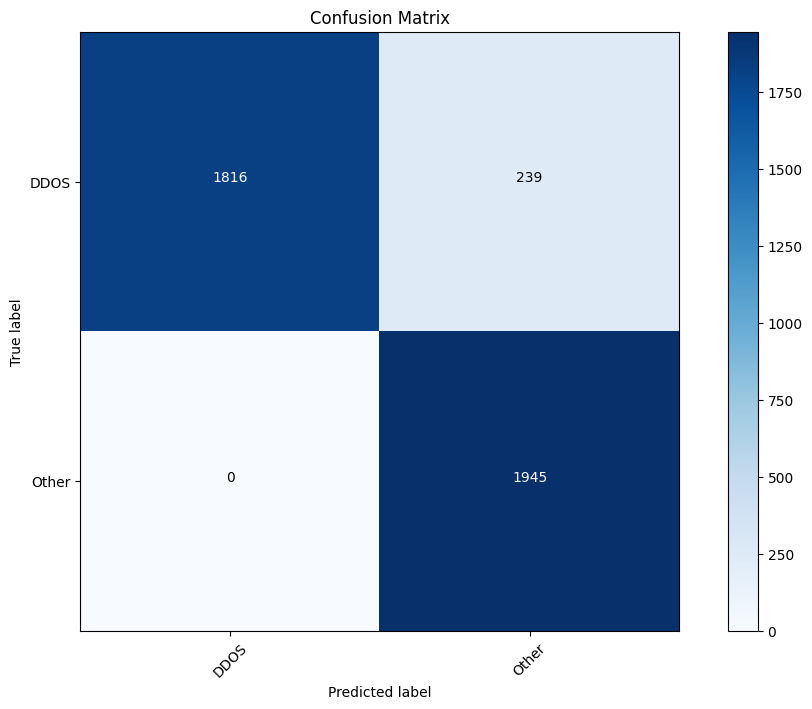

In [138]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Assuming your classes are named 'DDOS', 'Normal', and 'Other'
plot_confusion_matrix(cm, classes=['DDOS', 'Other'])

In [139]:
from sklearn.metrics import f1_score

f1 = f1_score(true, pred)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9421


In [ ]:
torch.save(model, 'ddos_cnn_model.pth')

In [58]:
losses, times, accuracies

([0.026772374838440856,
  0.014939200107731629,
  0.013203356270931709,
  0.0123502258603162,
  0.01564459268938006,
  0.011979394227877764,
  0.011133208617416667,
  0.008356628014749835,
  0.005397392977171197,
  0.01305569207687318,
  0.00861787025508544,
  0.005805049562515554,
  0.009193565020437904,
  0.009051411435767778,
  0.0030364772064926954,
  0.005570148655685494,
  0.0019433110374047244,
  0.006818537863563818,
  0.007417301956493232,
  0.005447490738759131,
  0.003376008791073833],
 [110.82984471321106,
  94.93877053260803,
  103.50078821182251,
  99.20205998420715,
  103.66176795959473,
  98.07132911682129,
  101.70803499221802,
  105.09132432937622,
  103.76076555252075,
  101.89930605888367,
  104.11514806747437,
  107.97387647628784,
  103.49810743331909,
  105.1833655834198,
  104.80934071540833,
  104.51566123962402,
  104.45177674293518,
  104.56206893920898,
  105.06345677375793,
  104.20622181892395,
  104.51675605773926],
 [99.10908642086129,
  99.5767973489523

### Actual implementation (3)

In [59]:
class Multiclass(nn.Module):
    def __init__(self):
        super(Multiclass, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3, stride=1, padding=1),
        #PrintShape(),
        nn.BatchNorm1d(15),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2)
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv1d(in_channels=15, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm1d(32),
       # pool2 = nn.MaxPool1d(kernel_size=2),
        nn.ReLU()
        )
        
        self.layer3 = nn.Sequential(
        nn.Linear(32*22, 64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(64,2)
        )
        
    
    def forward(self, x):
        #print("Initial input shape:", x.shape)
        x = self.layer1(x)
        x = self.layer2(x)
        #print("Before reshaping:", x.shape)
        x = x.view(x.size(0),-1)
        #print("After reshaping:", x.shape)
        x = self.layer3(x)
        return x

In [60]:
def initialize_population(population_size):
    # Generate random initial positions for crows
    return [np.random.uniform(low=-1.0, high=1.0, size=45) for _ in range(population_size)]

In [61]:
def update_positions(population, global_best_position, inertia_weight=0.5, exploration_rate=0.1):
    # Update positions of crows based on their previous positions and the global best position
    # Use some exploration strategy (e.g., randomization, inertia, etc.)
    updated_population = []
    for crow_position in population:
        # Calculate crow movement towards the global best position
        crow_movement = inertia_weight * (global_best_position - crow_position)
        
        # Add some randomness for exploration
        exploration = exploration_rate * np.random.uniform(-1, 1, size=crow_position.shape)
        
        # Update crow position
        new_crow_position = crow_position + crow_movement + exploration
        
        # Append the updated position to the list
        updated_population.append(new_crow_position)
    
    return updated_population

In [62]:
def update_model_parameters(model, crow_position):
    # Update model parameters based on crow position
    crow_position_tensor = torch.tensor(crow_position, dtype=torch.float32)

    # Total number of parameters in the model
    total_params = sum(p.numel() for p in model.parameters())

    # Iterate through model parameters and update them based on the crow position
    param_index = 0
    for param in model.parameters():
        if param_index >= 45:
            break  # Break the loop if all parameters have been updated
        # Calculate the number of elements in the parameter tensor
        num_elements = param.numel()
        print(f'prarm_idx: {param_index}, numel: {num_elements}')
        # Extract a slice of the crow position tensor with the same size as the parameter tensor
        param_update = crow_position_tensor[param_index:param_index+num_elements]

        # Reshape the parameter update to match the shape of the parameter tensor
        param_update = param_update.view(param.size())

        # Update the parameter tensor with the crow position values
        param.data = param_update

        # Move to the next position in the crow position tensor
        param_index += 15

        # Ensure param_index does not exceed the total number of parameters
        


In [142]:
def train_and_evaluate(model, data_loader, criterion, optimizer):
    # Train the model on the dataset and evaluate performance
    # Return performance metric (e.g., accuracy)
    model.train()

    # Iterate over the dataset in batches
    for inputs, labels in data_loader:
        # print(inputs.shape)
        # print(labels)
        
        # Forward pass
        inputs = inputs.unsqueeze(-1).permute(0,2,1)
        # print(inputs.shape)
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Set the model to evaluation mode
    model.eval()

    # Evaluate the model on the entire dataset
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            # Forward pass
            inputs = inputs.unsqueeze(-1).permute(0,2,1)
            outputs = model(inputs)
            
            # Convert outputs and labels to numpy arrays
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Calculate evaluation metric (e.g., accuracy)
    accuracy = accuracy_score(targets, predictions)
    print("Accuracy:", accuracy)

    return accuracy

In [143]:
test_pred = []

In [144]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
            outputs = model(inputs)
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(targets, predictions)
    # test_pred = predictions
    print("Testing Accuracy:", accuracy)
    return accuracy

In [121]:
losses_cso = []
times_cso = []
accuracies_cso = []

In [129]:
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer):
    global losses_cso, times_cso, accuracies_cso
    model.train()
    start_time = time.time()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
        labels = labels

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses_cso.append(avg_loss)

    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
            labels = labels
            outputs = model(inputs)
            predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    accuracy = accuracy_score(targets, predictions)
    accuracies_cso.append(accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time
    times_cso.append(epoch_time)

    print(f"Avg loss = {avg_loss:.4f} --- Time = {epoch_time:.2f}s --- Accuracy = {accuracy:.2f}%")

    return accuracy

In [130]:
model3 = Multiclass()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [131]:
def evaluate_fitness(model, data, criterion, population):
    # Evaluate the fitness (performance metric) of each crow (solution)
    fitness_values = []
    for crow_position in population:
        # Update model parameters
        # print(model)
        update_model_parameters(model, crow_position)

        # Train the model and evaluate performance
        # Calculate accuracy or other performance metric
        accuracy = train_and_evaluate(model, data, criterion,optimizer)

        fitness_values.append(accuracy)  # Or any other performance metric

    return np.array(fitness_values)

In [132]:
def evaluate_fitness(model, train_loader, test_loader, criterion, population):
    fitness_values = []
    for crow_position in population:
        update_model_parameters(model, crow_position)
        accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)
        fitness_values.append(accuracy)
    return np.array(fitness_values)

In [133]:
def cso_optimization(population_size, max_iterations, model, data, criterion):
    # Initialize population randomly or using some strategy
    population = initialize_population(population_size)

    # Main optimization loop
    for iteration in range(max_iterations):
        # Evaluate fitness of each crow (solution)
        # print(population[1].shape)
        fitness_values = evaluate_fitness(model, data, criterion, population)

        # Update global best position
        global_best_index = np.argmax(fitness_values)
        global_best_position = population[global_best_index]
        # print(global_best_position)

        # Update crow positions
        population = update_positions(population, global_best_position)

        # Update model parameters based on best solution found
        update_model_parameters(model, global_best_position)

In [134]:
def cso_optimization(population_size, max_iterations, model, train_loader, test_loader, criterion):
    population = initialize_population(population_size)
    for iteration in range(max_iterations):
        fitness_values = evaluate_fitness(model, train_loader, test_loader, criterion, population)
        global_best_index = np.argmax(fitness_values)
        global_best_position = population[global_best_index]
        population = update_positions(population, global_best_position)
        update_model_parameters(model, global_best_position)

In [135]:
y.value_counts()

category
0    576778
1     91638
Name: count, dtype: int64

In [136]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Perform CSO optimization
cso_optimization(population_size=10, max_iterations=1, model=model3, train_loader=train_loader, test_loader=test_loader, criterion=criterion)

prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0302 --- Time = 118.19s --- Accuracy = 1.00%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0328 --- Time = 124.25s --- Accuracy = 1.00%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0305 --- Time = 125.22s --- Accuracy = 1.00%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0312 --- Time = 123.06s --- Accuracy = 1.00%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0190 --- Time = 121.37s --- Accuracy = 1.00%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0202 --- Time = 115.53s --- Accuracy = 0.99%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Avg loss = 0.0196 --- Time = 123.60s --- Accuracy = 1.00%
prarm_idx: 0, numel: 45
prarm_idx: 15, numel: 15
prarm_idx: 30, numel: 15
Av

In [140]:
losses = losses[:10]
accuracies = accuracies[:10]
times = times[:10]

In [141]:
epochs = range(1, len(accuracies) + 1)

In [145]:
accuracies_cso = [i*100 for i in accuracies_cso]

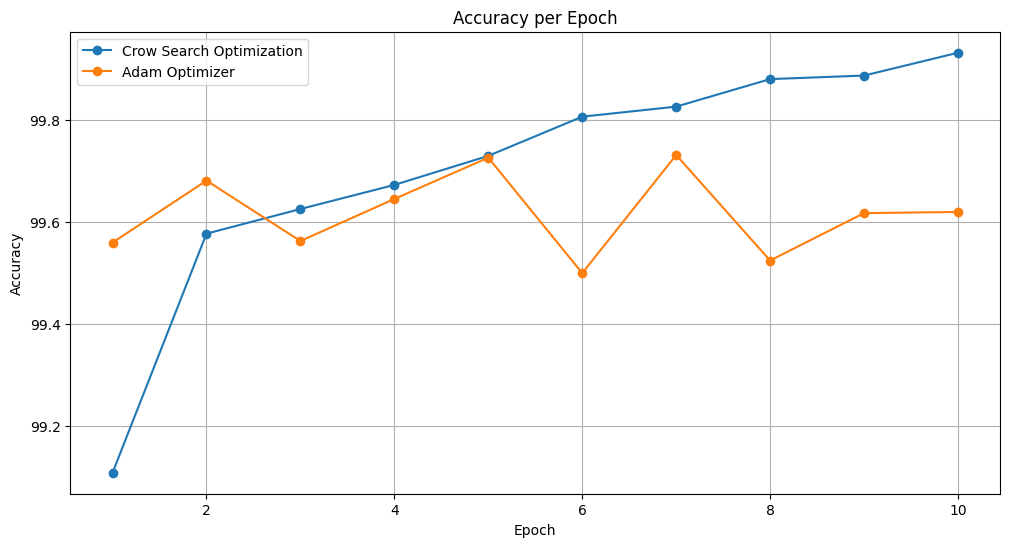

In [151]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracies, label='Crow Search Optimization', marker='o')
plt.plot(epochs, accuracies_cso, label='Adam Optimizer', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

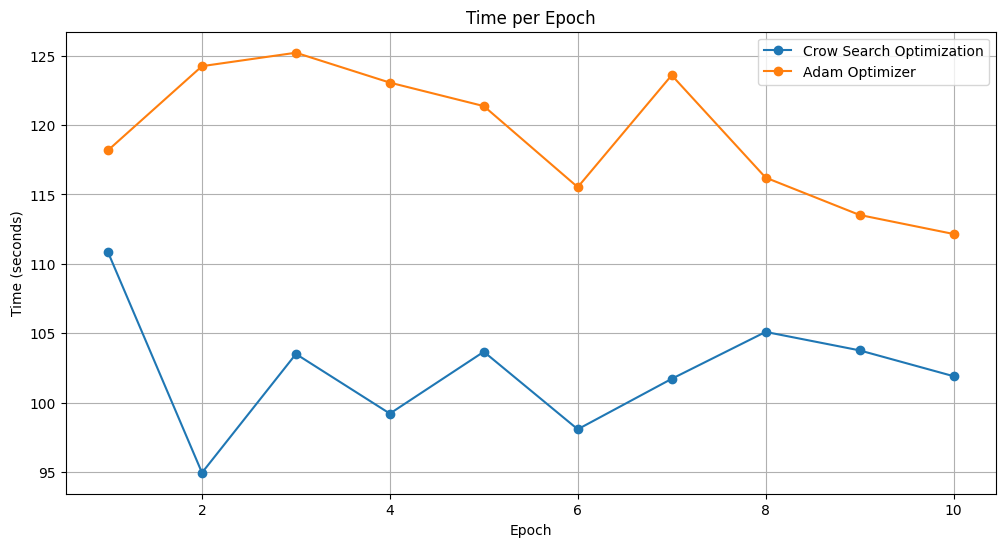

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, times, label='Crow Search Optimization', marker='o')
plt.plot(epochs, times_cso, label='Adam Optimizer', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [154]:
accuracies

[99.10908642086129,
 99.57679734895237,
 99.62504581734402,
 99.6721722283312,
 99.72902313682368,
 99.80569705946156,
 99.82533306403955,
 99.87919181945348,
 99.88611117344763,
 99.93080646005849]

In [138]:
times_cso, losses_cso, accuracies_cso

([118.18854665756226,
  124.25189757347107,
  125.22058033943176,
  123.06470561027527,
  121.37195992469788,
  115.52838063240051,
  123.59891271591187,
  116.21579313278198,
  113.52357792854309,
  112.15270590782166],
 [0.02542378989884999,
  0.030207861494420625,
  0.03281625653371777,
  0.030459842619355835,
  0.031158236558190496,
  0.018996780138631524,
  0.02019757924035325,
  0.019567149784704353,
  0.02915697485995276,
  0.025934357296824043,
  0.03912828719175726],
 [0.9955940875497442,
  0.996805900481733,
  0.9956240088567069,
  0.9964468447981808,
  0.9972547200861733,
  0.9949956614104905,
  0.9973070823733581,
  0.9952425121929326,
  0.9961700727087759,
  0.996192513688998])

In [157]:
from sklearn.model_selection import train_test_split as tts

Xtrain, Xtest, ytrain, ytest = tts(X, y, train_size=0.8, random_state=42)

In [158]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(Xtrain, ytrain)

In [ ]:
y_pred = lr_model.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(Xtrain, ytrain)
y_pred = rf_model.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)

In [ ]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(Xtrain, ytrain)
y_pred = svm_model.predict(Xtest)
accuracy = accuracy_score(ytest, y_pred)
accuracy

In [ ]:
p = []
targ = []
ip = []

for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
        outputs = model3(inputs)

        ip.extend(inputs)
        p.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        targ.extend(labels.cpu().numpy())

KeyboardInterrupt: 

In [174]:
df.head(1)

,stime,proto_number,saddr,daddr,pkts,bytes,ltime,seq,dur,mean,...,state_CON,state_ECO,state_FIN,state_INT,state_MAS,state_NRS,state_REQ,state_RST,state_TST,state_URP
0,0.394231,3,-0.003309,-0.12099,0.015126,-0.004334,0.394231,109223,0.004998,0.770506,...,0,0,0,1,0,0,0,0,0,0


In [190]:
ip[1][0][6].item()

0.3942297399044037

In [189]:
(ip[1][0][5].item() * s[5]) + m[5]

1527870246.274043

In [178]:
m[4], s[4]

(2039.7210233919004, 262984.05756207026)

In [177]:
col_to_scale = ['stime','saddr','daddr', 'pkts', 'bytes', 'ltime', 'dur', 
                'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
                'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'TnBPSrcIP', 'TnBPDstIP',
                'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport',
                'Pkts_P_State_P_Protocol_P_DestIP', 'Pkts_P_State_P_Protocol_P_SrcIP']

In [155]:
count_0 = 0
l=[]
count_1 = 1
x = 0
for i in range(len(p)):
    if p[i] != targ[i]:
        x+=1
    elif p[i] == 0 and p[i] == targ[i]:
        l.append(i)
x

35116

In [156]:
l

[1,
 3,
 6,
 7,
 11,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 26,
 27,
 28,
 31,
 33,
 35,
 36,
 38,
 43,
 45,
 46,
 47,
 48,
 49,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 62,
 63,
 64,
 65,
 66,
 68,
 69,
 70,
 72,
 73,
 77,
 78,
 79,
 80,
 82,
 87,
 89,
 90,
 95,
 96,
 100,
 101,
 105,
 106,
 108,
 109,
 116,
 117,
 118,
 120,
 122,
 124,
 125,
 126,
 128,
 130,
 135,
 136,
 138,
 142,
 143,
 147,
 148,
 149,
 150,
 151,
 154,
 155,
 156,
 160,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 179,
 181,
 183,
 185,
 186,
 187,
 188,
 190,
 194,
 197,
 198,
 199,
 201,
 202,
 203,
 204,
 206,
 208,
 211,
 212,
 216,
 217,
 218,
 220,
 221,
 222,
 224,
 225,
 227,
 228,
 230,
 231,
 235,
 237,
 238,
 242,
 244,
 246,
 247,
 248,
 250,
 252,
 255,
 258,
 259,
 260,
 261,
 264,
 266,
 267,
 269,
 270,
 272,
 274,
 276,
 278,
 282,
 284,
 287,
 290,
 292,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 303,
 304,
 305,
 307,
 309,
 311,
 312,
 313,
 314,
 3

In [157]:
len(p)

133684

In [62]:
c = 0
for inp, op in test_loader:
    c+=1
    if c == 2:
        break

In [63]:
op

tensor([0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1])

In [64]:
data = data_loader # Your dataset
criterion = nn.CrossEntropyLoss()  

# Perform CSO optimization
cso_optimization(population_size=10, max_iterations=1, model=model3, data=data, criterion=criterion)

TypeError: cso_optimization() got an unexpected keyword argument 'data'

In [58]:
import pickle
import h5py

In [59]:
with open('cso_ddos_model.pkl', 'wb') as f:
    pickle.dump(model3.state_dict(), f)

In [60]:
model_dict = model3.state_dict()
with h5py.File('cso_ddos_model.h5', 'w') as f:
    for key, value in model_dict.items():
        f.create_dataset(key, data=value.cpu().numpy())

In [61]:
torch.save(model3.state_dict(), 'cso_ddos_model.pth')

In [69]:
def initialize_population(population_size):
    return [np.random.uniform(low=-1.0, high=1.0, size=45) for _ in range(population_size)]

def update_positions(population, global_best_position, inertia_weight=0.5, exploration_rate=0.1):
    updated_population = []
    for crow_position in population:
        crow_movement = inertia_weight * (global_best_position - crow_position)
        exploration = exploration_rate * np.random.uniform(-1, 1, size=crow_position.shape)
        new_crow_position = crow_position + crow_movement + exploration
        updated_population.append(new_crow_position)
    return updated_population

def update_model_parameters(model, crow_position):
    crow_position_tensor = torch.tensor(crow_position, dtype=torch.float32)
    param_index = 0
    for param in model.parameters():
        if param_index >= 45:
            break
        num_elements = param.numel()
        param_update = crow_position_tensor[param_index:param_index + num_elements]
        param_update = param_update.view(param.size())
        param.data = param_update
        param_index += 15

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    train_predictions, train_targets = [], []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
            outputs = model(inputs)
            train_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            train_targets.extend(labels.cpu().numpy())
    train_accuracy = accuracy_score(train_targets, train_predictions)
    # train_f1 = f1_score(train_targets, train_predictions, average='weighted')

    test_predictions, test_targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(-1).permute(0, 2, 1)
            outputs = model(inputs)
            test_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            test_targets.extend(labels.cpu().numpy())
    test_accuracy = accuracy_score(test_targets, test_predictions)
    # test_f1 = f1_score(test_targets, test_predictions, average='weighted')

    print("Training Accuracy:", train_accuracy)
    # print("Training F1 Score:", train_f1)
    print("Testing Accuracy:", test_accuracy)
    # print("Testing F1 Score:", test_f1)

    return train_accuracy, test_accuracy

model3 = Multiclass()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

def evaluate_fitness(model, train_loader, test_loader, criterion, population):
    train_accuracies = []
    test_accuracies = []
    for crow_position in population:
        update_model_parameters(model, crow_position)
        train_accuracy, test_accuracy = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    return np.array(train_accuracies), np.array(test_accuracies)

def cso_optimization(population_size, max_iterations, model, train_loader, test_loader, criterion):
    population = initialize_population(population_size)
    all_train_accuracies = []
    all_test_accuracies = []
    for iteration in range(max_iterations):
        train_accuracies, test_accuracies = evaluate_fitness(model, train_loader, test_loader, criterion, population)
        all_train_accuracies.append(np.mean(train_accuracies))
        all_test_accuracies.append(np.mean(test_accuracies))
        global_best_index = np.argmax(test_accuracies)
        global_best_position = population[global_best_index]
        population = update_positions(population, global_best_position)
        update_model_parameters(model, global_best_position)

    return train_accuracies, test_accuracies

In [70]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

criterion = nn.CrossEntropyLoss()

# Perform CSO optimization
train_accuracies, test_accuracies = cso_optimization(population_size=10, max_iterations=1, model=model3, train_loader=train_loader, test_loader=test_loader, criterion=criterion)

Training Accuracy: 0.9901855135725003
Testing Accuracy: 0.9896606285464863
Training Accuracy: 0.9493929886782158
Testing Accuracy: 0.9497490178961152
Training Accuracy: 0.9905606329286591
Testing Accuracy: 0.9900152771715408
Training Accuracy: 0.9476196971763743
Testing Accuracy: 0.9483031427324312
Training Accuracy: 0.930384667848861
Testing Accuracy: 0.9319893059799215


KeyboardInterrupt: 

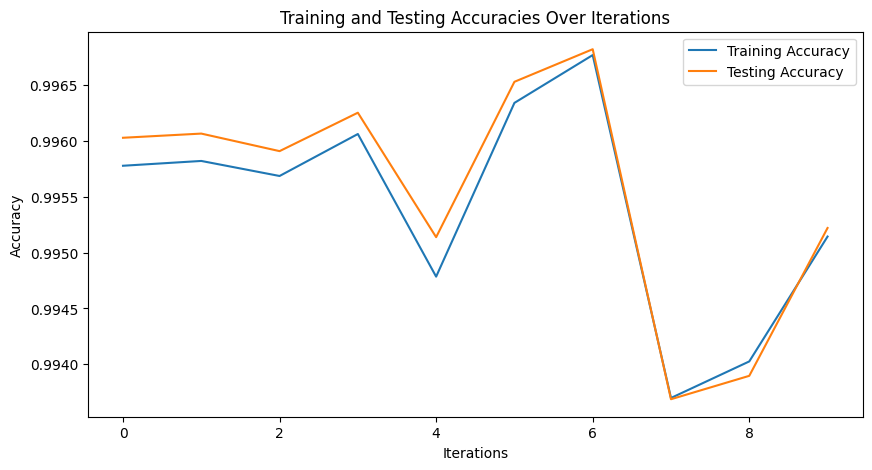

In [78]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies Over Iterations')
plt.legend()
plt.show()

### USING THE MODEL

In [40]:
from model import Multiclass
model = torch.load('ddos_cnn_model_cso.pth', map_location=torch.device('cpu'))
model.eval()

Multiclass(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=704, out_features=64, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [41]:
def predict(features):
     
    with torch.no_grad():

        output = model(features)
        _, prediction = torch.max(output, 1)

        if prediction.item() == 1:
            output = False
        else:
            output = True
    return output

In [43]:
#Connv the ip addresses
#Scale the parameters
#pass them to the model using the above function